# Análise de Exoplanetas

In [32]:
import os

# Numpy
import numpy as np

# Pandas
import pandas as pd

## Matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

## Cross validation, GrideSearch (Model selection).
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [6]:
originalDF = pd.read_csv('database/koi_data.csv', sep=',')
originalDF.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


## Normalizando os dados

In [12]:
originalDF.columns

Index(['kepoi_name', 'koi_disposition', 'koi_period', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad',
       'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor',
       'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_steff',
       'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass', 'koi_kepmag',
       'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag',
       'koi_kmag', 'koi_fwm_stat_sig', 'koi_fwm_sra', 'koi_fwm_sdec',
       'koi_fwm_srao', 'koi_fwm_sdeco', 'koi_fwm_prao', 'koi_fwm_pdeco',
       'koi_dicco_mra', 'koi_dicco_mdec', 'koi_dicco_msky', 'koi_dikco_mra',
       'koi_dikco_mdec', 'koi_dikco_msky'],
      dtype='object')

In [17]:
dataset_path = "database/df.csv"
if os.path.exists(dataset_path):
    df = pd.read_csv(dataset_path, sep=",")
else:
    target = originalDF["koi_disposition"]
    df_values = originalDF.drop(columns=["koi_disposition","kepoi_name"], axis=1)
    feats = normalize(df_values.values)
    df = pd.DataFrame(feats, columns=list(df_values.columns))
    df["koi_disposition"] = target
    df.to_csv(dataset_path, sep=",", index=False)


In [19]:
df.head(20)

,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,...,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky,koi_disposition
0,0.001710,0.000026,0.000533,0.110979,0.000004,5.781357e-04,0.000407,0.000015,0.016158,0.142914,...,1.694060e-04,-3.604382e-08,-9.912050e-08,-1.802191e-06,3.604382e-05,3.604382e-05,1.441753e-05,5.586792e-05,0.000058,CONFIRMED
1,0.009815,0.000106,0.000813,0.157778,0.000005,5.453491e-04,0.000510,0.000049,0.016155,0.079899,...,2.218421e-04,1.190372e-07,-1.893774e-07,7.034017e-05,0.000000e+00,7.034017e-05,8.837611e-05,2.164313e-05,0.000090,CONFIRMED
2,0.000172,0.000126,0.000238,0.798887,0.000038,2.183314e-05,0.003309,0.000003,0.006634,0.137940,...,1.977640e-07,2.986236e-07,-1.404124e-07,-2.462162e-05,1.453565e-05,2.857690e-05,-2.541267e-05,9.789317e-06,0.000027,FALSE POSITIVE
3,0.000401,0.000111,0.000263,0.095887,0.000004,3.157066e-04,0.000437,0.000006,0.013575,0.223467,...,3.655575e-05,1.271504e-08,-1.112566e-08,4.768141e-06,-1.430442e-05,1.589380e-05,1.112566e-05,3.178761e-06,0.000011,CONFIRMED
4,0.001146,0.000182,0.000782,0.036394,0.000029,7.552898e-07,0.006106,0.000013,0.009487,0.208989,...,3.751532e-03,4.718615e-07,-8.643007e-07,-7.017188e-04,1.200677e-03,1.390668e-03,-7.065464e-04,1.201144e-03,0.001393,FALSE POSITIVE
5,0.002275,0.000007,0.000500,0.695808,0.000009,5.190489e-04,0.000816,0.000016,0.012732,0.084953,...,-6.229889e-06,3.681298e-08,6.937831e-08,5.805124e-06,-2.123826e-06,6.229889e-06,7.079419e-07,4.247652e-06,0.000004,CONFIRMED
6,0.000143,0.000047,0.000101,0.822400,0.000007,1.060654e-04,0.000754,0.000002,0.004878,0.077380,...,6.160344e-06,-6.934721e-09,4.507569e-08,-5.201041e-07,-1.733680e-05,1.733680e-05,8.668402e-07,-1.560312e-05,0.000016,CONFIRMED
7,0.000306,0.000055,0.000278,0.794990,0.000008,5.682634e-05,0.001268,0.000004,0.007406,0.132213,...,-5.189422e-06,8.692499e-10,3.129300e-08,1.216950e-06,-1.130025e-06,1.738500e-06,-2.433900e-06,1.529880e-05,0.000015,CONFIRMED
8,0.000620,0.000009,0.000440,0.021922,0.000002,2.967324e-04,0.000194,0.000008,0.015005,0.201667,...,7.524870e-05,-8.360967e-09,-8.360967e-09,4.013264e-05,-2.508290e-05,4.849361e-05,2.675509e-05,-2.173851e-05,0.000035,CONFIRMED
9,0.000609,0.000131,0.000192,0.949948,0.000086,6.728234e-05,0.007950,0.000005,0.004391,0.039775,...,-2.007230e-06,0.000000e+00,5.282184e-09,4.753965e-07,-4.753965e-07,6.866839e-07,7.764810e-06,1.954408e-06,0.000008,FALSE POSITIVE


## Base Line (Nayve Bayes)
Construindo baseline com algoritimo Naive Bayes. Para construir o baseline com este algoritimo utilizamores a versão Gaussian Naive Bayes para lidar com valores reais.

In [35]:

folds = 4
X = df.drop(columns=["koi_disposition"], axis=1).values
Y = df["koi_disposition"]
clf = GaussianNB()
scores = ["accuracy", "f1_macro"]
for score in scores:
    print(f"Média ({score}): ", sum(cross_val_score(clf, X, Y, cv=folds, scoring=score, n_jobs=15))/folds)


Média (accuracy):  0.9194569266244901
Média (f1_macro):  0.9173511820456584


## Decision Tree

Avaliação do algoritimo decision tree variando a altura máxima da árvore, (permitindo altura ilimitada).

In [37]:
X = df.drop(columns=["koi_disposition"], axis=1).values
Y = df["koi_disposition"]
folds = 4

params = {'max_depth': list(range(1, 100))}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=3, cv=folds, n_jobs=20)

grid_search_cv.fit(X, Y)

Fitting 4 folds for each of 99 candidates, totalling 396 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=20,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             verbose=3)

Text(0, 0.5, 'Accuracy (%)')

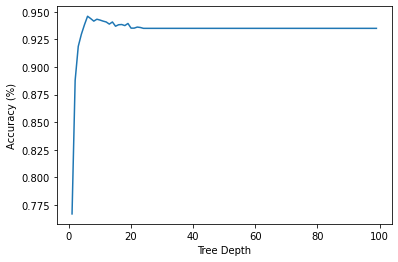

In [50]:
mean_scores = grid_search_cv.cv_results_["mean_test_score"]
x = list(range(1,100))
fig, ax = plt.subplots()
ax.plot(x, mean_scores)
ax.set_xlabel("Tree Depth")
ax.set_ylabel("Accuracy (%)")